# Detection of Vote Fraud

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2

## Theoretical Benford's law

Benford's law states that in many naturally occurring collections of numbers, the leading digit is likely to be small. In sets that obey Benford's law, in the first position, the number 1 appears as the leading significant digit about 30% of the time, while larger digits occur in that position less frequently: 9 as the first digit less than 5% of the time. Here, a function that compute the theoretical Benford's law is implemented. This function can be used for alle digits (0-9) but for the first position the digit 0 is not allowed.

### Functions

In [2]:
def benford_nth_digit_probabilities(n):
    """
    Calculate the probabilities for all digits (0-9) appearing at the n-th position.
    For the first position, this is not applicable to digit 0.
    """
    probabilities = {}
    if n == 1:
        probabilities[0] = 0
        for d in range(1, 10):
            probabilities[d] = math.log10(1 + 1 / d)
    else:
        for d in range(10):
            total_sum = 0
            for k in range(10**(n-2), 10**(n-1)):
                total_sum += math.log10(1 + 1 / (10 * k + d))
            probabilities[d] = total_sum
    return probabilities


Now the function is generalized for other bases of numbers.

In [3]:
import math

def benford_nth_digit_probabilities_gen(base=10, n=1):
    """
    Calculate the probabilities for all digits (0 to base-1) appearing at the n-th position
    in a numeric system of the specified base.
    For the first position, this is not applicable to digit 0.
    """
    probabilities = {}
    
    if n == 1:
        # For the first digit, digit 0 is not allowed.
        probabilities[0] = 0
        for d in range(1, base):
            # Use logarithm in the specified base for the calculation
            probabilities[d] = math.log(1 + 1 / d, base)
    else:
        # For subsequent digits, all digits (0 to base-1) are considered
        for d in range(base):
            total_sum = 0
            # Sum over possible positions for digits
            for k in range(base**(n-2), base**(n-1)):
                total_sum += math.log(1 + 1 / (base * k + d), base)
            probabilities[d] = total_sum
    
    return probabilities



In [4]:
Benford_theory = pd.DataFrame([benford_nth_digit_probabilities(1), benford_nth_digit_probabilities(2), benford_nth_digit_probabilities(3), benford_nth_digit_probabilities(4)])
Benford_theory = Benford_theory.T
Benford_theory.columns = ['First position', 'Second position', 'Third position', 'Fourth position']

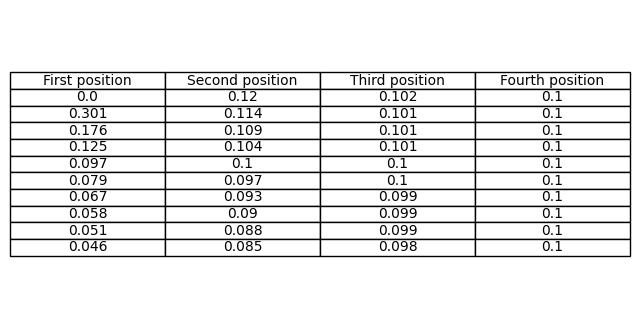

<Figure size 640x480 with 0 Axes>

In [5]:
#only 3 decimal places
Benford_theory = Benford_theory.round(3)

# table to represent the probabilities
fig, ax = plt.subplots(figsize=(8, 4))  
ax.axis('tight')
ax.axis('off')
ax.table(cellText=Benford_theory.values, colLabels=Benford_theory.columns, cellLoc='center', loc='center')

plt.show()
plt.savefig('table_with_sum_probabilities.png', dpi=300, bbox_inches='tight')
#write all the data in a type that can be used in a LaTeX table
Benford_theory.to_latex('table_with_sum_probabilities.tex', float_format="%.3f")


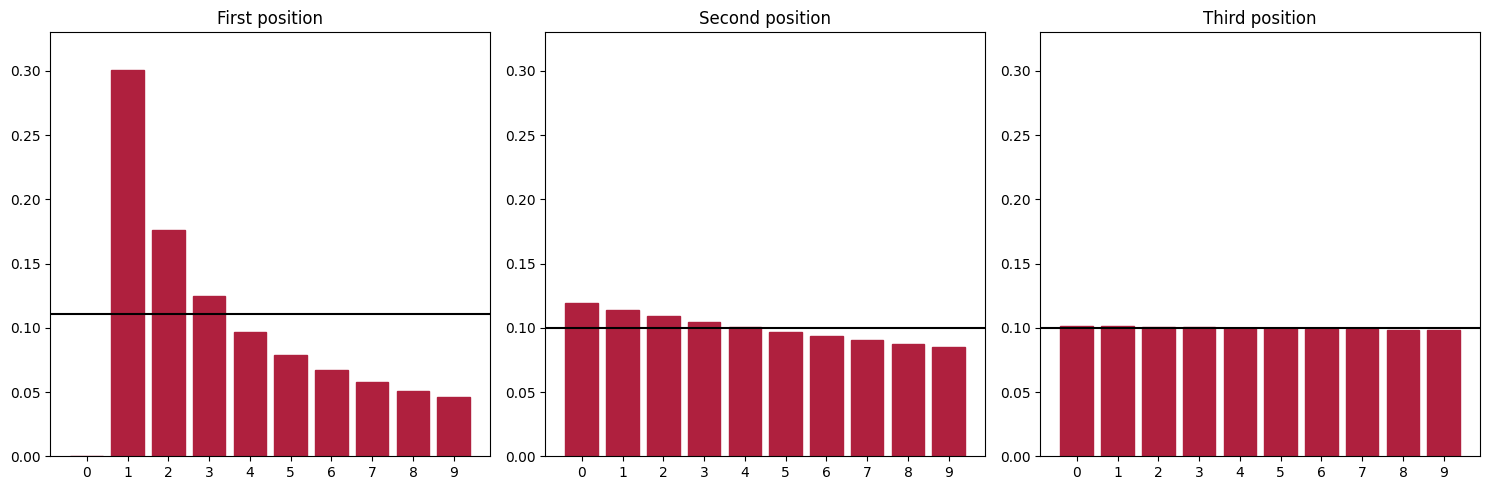

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax in axs:
    ax.set_ylim(0, 0.33)

for ax in axs:
    ax.set_xticks(range(10))

axs[0].bar(benford_nth_digit_probabilities(1).keys(), benford_nth_digit_probabilities(1).values())
axs[0].set_title('First position')
axs[1].bar(benford_nth_digit_probabilities(2).keys(), benford_nth_digit_probabilities(2).values())
axs[1].set_title('Second position')
axs[2].bar(benford_nth_digit_probabilities(3).keys(), benford_nth_digit_probabilities(3).values())
axs[2].set_title('Third position')

#use the color #af203e in HEX for the bars
for ax in axs:
    for bar in ax.patches:
        bar.set_color('#af203e')

for ax in axs:
    if ax.get_title() == 'First position':
        ax.axhline(y=1/9, color='black')
    else:
        ax.axhline(y=1/10, color='black')

plt.tight_layout()
plt.show()



In [7]:
def Benford_theory_firsttwo_digits():
    """
    Calculate the probabilities for the first two digits (10-99) with Benford's law that is 1/log(1+1/d) where d is the digit.
    """
    probabilities = {}
    for d in range(10, 100):
        probabilities[d] = math.log10(1 + 1 / d)
    return probabilities


Text(0.5, 1.0, 'First two digits')

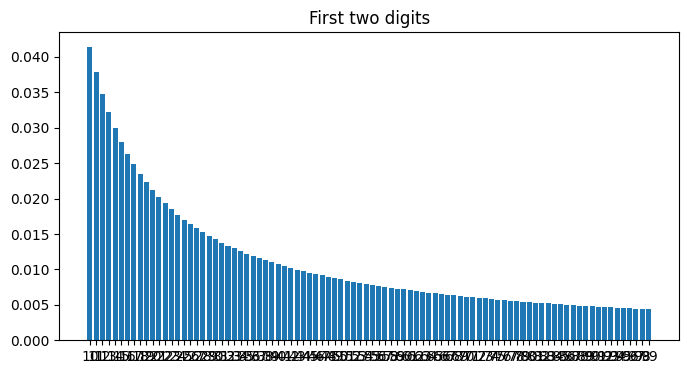

In [8]:
#plot Benford_theory_firsttwo_digits
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xticks(range(10, 100))
ax.bar(Benford_theory_firsttwo_digits().keys(), Benford_theory_firsttwo_digits().values())
ax.set_title('First two digits')


#### Application of the Benford's law to the data

In this notebook, a function that computes the probability of the different digits is implemented. The function also take as input the position that the user want to compute the probability. Take care that for the numbers with decimal values, the point is removed. The results are also calcolate for the digits from 0 to 9 but the digit 0 is not allowed in the first position so is 0 everytimes.

In [9]:
def data_digit_probabilities(data, position):
    """
    Calculate the probabilities for the digit (0-9) at a given position according to Benford's Law for a list of numbers.
    Returns a dictionary with digits as keys and their probabilities as values.
    
    Parameters:
        data (list): A list of numerical data (int or float).
        position (int): The position of the digit to analyze (1 for the first digit, 2 for the second, etc.).
    
    Returns:
        probabilities (dict): A dictionary with digit keys (0-9) and their probabilities as values.
    """
    probabilities = {}
    for n in range(0, 10):
        probabilities[n] = 0
    total_count = 0
    
    for number in data:
        str_number = str(abs(number)).replace('.', '')

        if len(str_number) >= position:
            digit = int(str_number[position - 1])
            probabilities[digit] += 1
            total_count += 1
    
    # Compute the probabilities instead of counts
    if total_count > 0:
        for n in range(0, 10):
            probabilities[n] /= total_count
    
    return probabilities


In [10]:
def data_digit_probabilities_gen(data, base=10, position=1):
    """
    Calculate the probabilities for the digit (0 to base-1) at a given position according to Benford's Law for a list of numbers.
    Returns a dictionary with digits as keys and their probabilities as values.
    
    Parameters:
        data (list): A list of numerical data (int or float).
        base (int): The base of the numeric system (e.g., 10 for decimal, 16 for hexadecimal).
        position (int): The position of the digit to analyze (1 for the first digit, 2 for the second, etc.).
    
    Returns:
        probabilities (dict): A dictionary with digit keys (0 to base-1) and their probabilities as values.
    """
    probabilities = {n: 0 for n in range(0, base)}
    total_count = 0

    for number in data:
        str_number = str(abs(number)).replace('.', '')

        if len(str_number) >= position:
            digit = int(str_number[position - 1], base=10)  # Assumes input data is in base 10
            if digit < base:
                probabilities[digit] += 1
                total_count += 1
    
    # Compute the probabilities instead of counts
    if total_count > 0:
        for n in range(0, base):
            probabilities[n] /= total_count
    
    return probabilities


In [11]:
def data_digit_probabilities_firsttwo(data):
    """
    Calculate the probabilities for the first two digits (10-99) according to Benford's Law for a list of numbers.
    Returns a dictionary with two-digit numbers as keys and their probabilities as values.

    Parameters:
        data (list): A list of numerical data (int or float).

    Returns:
        probabilities (dict): A dictionary with two-digit number keys (10-99) and their probabilities as values.
    """

    probabilities = {}
    for n in range(10, 100):
        probabilities[n] = 0
    total_count = 0

    for number in data:
        str_number = str(abs(number)).replace('.', '')

        if len(str_number) >= 2:
            two_digits = int(str_number[:2])
            if two_digits >= 10:
                probabilities[two_digits] += 1
                total_count += 1

    # Compute the probabilities instead of counts
    if total_count > 0:
        for n in range(10, 100):
            probabilities[n] /= total_count

    return probabilities
    

In [12]:
#use the function above and test it with numbers from 1 to 1000
numbers = list(range(1, 1001))
first_digit_probabilities_for_numbers = data_digit_probabilities(numbers, 2)
first_digit_probabilities_for_numbers


{0: 0.10090817356205853,
 1: 0.09989909182643794,
 2: 0.09989909182643794,
 3: 0.09989909182643794,
 4: 0.09989909182643794,
 5: 0.09989909182643794,
 6: 0.09989909182643794,
 7: 0.09989909182643794,
 8: 0.09989909182643794,
 9: 0.09989909182643794}

#### Some statistical tests

A simple function to calculate deviations from Benford's law is here implemented. The deviation is calculated as the difference between the observed frequency and the formula of Benford's law. Delta that results is simply the maximum difference, in percent, between the probbilities of the first significant digit of the given distribution and the Benford's law. Thus, for example, delta=0 means that the distribution is perfectly following Benford's law, delta equal to 15.09 indicates that the probability of some digit d {1,2,3,4,5,6,7,8,9} differs from log10(1+1/d) by 15.09%.

In [13]:
def benford_deviation(observed_probabilities):
    """
    Calculates the deviation from Benford's Law.

    Args:
        observed_probabilities: Dictionary with keys 0 to 9 representing the observed probabilities for each first digit.

    Returns:
        The maximum deviation from Benford's Law, ignoring the key 0 as it does not apply to Benford's Law.
    """
    deviations = []
    for d in range(1, 10):  # Benford's Law applies to digits 1 through 9
        theoretical_probability = math.log10(1 + 1 / d)
        deviation = abs(observed_probabilities[d] - theoretical_probability) * 100
        deviations.append(deviation)

    return max(deviations)


##### Z-statistic

In [14]:
def calculate_z_statistic(DP, BP, N):
    """
    Calculates the Z-statistic for each pair of actual and expected proportions.

    Parameters:
    - DP: List of actual proportions
    - BP: List of expected proportions
    - N: Sample size

    Returns:
    - A list of Z-statistic values.
    """
    z_values = []
    for dp, bp in zip(DP, BP):
        # Compute the first term of the numerator
        absolute_difference = abs(dp - bp)

        # Compute the continuity correction
        continuity_correction = 1 / (2 * N)

        # Apply continuity correction only if it's smaller than |DP - BP|
        numerator = absolute_difference - continuity_correction if continuity_correction < absolute_difference else absolute_difference

        # Compute the denominator
        denominator = math.sqrt(bp * (1 - bp) / N)

        # Calculate the Z-statistic
        Z = numerator / denominator
        
        # Append the Z-statistic to the list
        z_values.append(Z)
    
    return z_values





##### MAD

In [15]:
#create a function that calculates the mean absolute deviation (MAD) from Benford's Law
#the function is calculated as, in the numerator the sum for i from 1 to k of Dataset probability (DP) - Benford probability (BP) and in the denominator K. K is the number of digits that are being analyzed.
#The number of row is not considered in the calculation of the MAD

def calculate_mad(DP, BP, K):
    """
    Calculates the Mean Absolute Deviation (MAD) from Benford's Law.

    Parameters:
    - DP: List of actual proportions
    - BP: List of expected proportions
    - K: Number of digits

    Returns:
    - The Mean Absolute Deviation (MAD) from Benford's Law.
    """
    mad = sum(abs(dp - bp) for dp, bp in zip(DP, BP)) / K
    return mad







In [16]:
#try MAD with following data
#DP= 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
#BP= 0.301, 0.176, 0.125, 0.097, 0.079, 0.067, 0.058, 0.051, 0.046
#K= 9
DP = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
BP = [0.301, 0.176, 0.125, 0.097, 0.079, 0.067, 0.058, 0.051, 0.046]
K = 9
calculate_mad(DP, BP, K)


0.4335555555555556

##### Chi-square test

In [17]:
def calculate_chi_square(DP, BP, N):
    DP_frequencies = [dp * N for dp in DP]
    BP_frequencies = [bp * N for bp in BP]
    chi_square = sum((df - bf)**2 / bf for df, bf in zip(DP_frequencies, BP_frequencies))
    df = len(DP) - 1
    alpha_levels = [0.001, 0.01, 0.05]
    
    print("N: ", N)
    print(f"Chi-Square statistic: {chi_square:.4f}")
    
    p_value = 1 - chi2.cdf(chi_square, df)
    print(f"p-value: {p_value:.4f}")
    
    for alpha in alpha_levels:
        critical_value = chi2.ppf(1 - alpha, df)
        print(f"Critical value at alpha={alpha*100}%: {critical_value:.4f}")
        if chi_square > critical_value:
            print(f"Reject null hypothesis at alpha={alpha*100}%")
        else:
            print(f"Fail to reject null hypothesis at alpha={alpha*100}%")




##### Mean of the significant digits


In [18]:
def calculate_fsd_mean(probabilities, start_digit=1, num_digits=9):
    """
    Calculate the mean of the first significant digit (FSD) for a dataset.

    Parameters:
    - probabilities (list): A list of probabilities (p_j) for each digit d_j (from `start_digit` to `start_digit + num_digits - 1`).
    - start_digit (int): The starting digit (default is 1).
    - num_digits (int): The total number of digits (default is 9).

    Returns:
    - float: The mean FSD value.
    """
    if len(probabilities) != num_digits:
        raise ValueError(f"The input probabilities list must contain {num_digits} values corresponding to digits from {start_digit} to {start_digit + num_digits - 1}.")

    # Compute the weighted mean of the first significant digit
    mean_fsd = sum(d * p for d, p in zip(range(start_digit, start_digit + num_digits), probabilities))
    return mean_fsd


##### Kolmogorov-Smirnov test
Kolmogorov-Smirnov test is a non-parametric test that compares the cumulative distribution of the data with the cumulative distribution of the theoretical distribution. The test statistic is the maximum absolute difference between the two cumulative distributions. The null hypothesis is that the two distributions are the same. The test is applied to the significant digits of the data.

The largest difference of the absolute values of these digits is also called supremum distance.

In [141]:
def calculate_ks_statistic(DP, BP, n):
    """
    Calculates the Kolmogorov-Smirnov (KS) statistic and compares it with critical values for different alpha levels.

    Parameters:
    - DP: List of actual proportions
    - BP: List of expected proportions
    - n: Sample size

    Returns:
    - A dictionary containing the KS statistic and results for the three critical values (alpha=0.001, 0.01, 0.05).
    """
    # Calculate the KS statistic
    ks_values = [abs(dp - bp) for dp, bp in zip(DP, BP)]
    ks_statistic = max(ks_values)

    # Define critical values for the three alpha levels
    critical_values = {
        0.001: 1.95 / math.sqrt(n),
        0.01: 1.63 / math.sqrt(n),
        0.05: 1.36 / math.sqrt(n)
    }

    # Compare KS statistic with critical values
    results = {}
    for alpha, critical_value in critical_values.items():
        if ks_statistic > critical_value:
            results[alpha] = f"Reject null hypothesis (KS={ks_statistic:.4f} > Critical={critical_value:.4f})"
        else:
            results[alpha] = f"Fail to reject null hypothesis (KS={ks_statistic:.4f} <= Critical={critical_value:.4f})"

    # Output results
    print(f"KS statistic: {ks_statistic:.4f}")
    for alpha, result in results.items():
        print(f"Alpha={alpha:.3f}: {result}")

    return {"KS_statistic": ks_statistic, "Results": results}

## Application of the function

### Uniform distribution


In [19]:
#create a unuform distribution with the proportion 9 proportion of 0.1111111111111111 for 
#the first digit and 0.1 for the other digits
#the first is called uniform_first_digit and the second uniform_other_digits
uniform_first_digit = [0.1111111111111111] * 9
uniform_other_digits = [0.1] * 10
uniform_10_90= [0.1] * 90

#### Statistical tests

##### Z-statistic

In [20]:
#apply the z statistic to the uniform_first_digit and uniform_other_digits
#the sample size is 1000

##### MAD

In [21]:
#apply the MAD to the uniform_first_digit and uniform_other_digits

BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(uniform_first_digit)
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Mean Absolute Deviation (MAD) from Benford's Law: 0.05971703510991756


In [22]:
# apply the MAD to the uniform_other_digits, second position
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(uniform_other_digits)
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Mean Absolute Deviation (MAD) from Benford's Law: 0.009405726701696863


In [23]:
#calculate the MAD for the first two digits
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(uniform_10_90)
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")



Mean Absolute Deviation (MAD) from Benford's Law: 0.08888888888888884


##### Chi-square test

In [24]:
uniform_first_digit

[0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111]

In [25]:
#apply the chi square to the uniform_first_digit
n=1000
calculate_chi_square(uniform_first_digit, list(benford_nth_digit_probabilities(1).values())[1:], n)




N:  1000
Chi-Square statistic: 401.6983
p-value: 0.0000
Critical value at alpha=0.1%: 26.1245
Reject null hypothesis at alpha=0.1%
Critical value at alpha=1.0%: 20.0902
Reject null hypothesis at alpha=1.0%
Critical value at alpha=5.0%: 15.5073
Reject null hypothesis at alpha=5.0%


In [26]:
#apply the chi square to the uniform_other_digits
calculate_chi_square(uniform_other_digits, list(benford_nth_digit_probabilities(2).values()),n)

N:  1000
Chi-Square statistic: 11.8526
p-value: 0.2217
Critical value at alpha=0.1%: 27.8772
Fail to reject null hypothesis at alpha=0.1%
Critical value at alpha=1.0%: 21.6660
Fail to reject null hypothesis at alpha=1.0%
Critical value at alpha=5.0%: 16.9190
Fail to reject null hypothesis at alpha=5.0%


In [27]:
#apply the chi square to the uniform_10_90
calculate_chi_square(uniform_10_90, list(Benford_theory_firsttwo_digits().values()),n)

N:  1000
Chi-Square statistic: 96973.5440
p-value: 0.0000
Critical value at alpha=0.1%: 135.9776
Reject null hypothesis at alpha=0.1%
Critical value at alpha=1.0%: 122.9422
Reject null hypothesis at alpha=1.0%
Critical value at alpha=5.0%: 112.0220
Reject null hypothesis at alpha=5.0%


##### FSD mean

In [28]:
#calculate also fsd mean of a Benford distribution
calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9)

3.440236967123206

In [29]:
#use the function calculate_fsd_mean to calculate the mean of the first significant digit for the uniform_first_digit
calculate_fsd_mean(uniform_first_digit, start_digit=1, num_digits=9)


5.0

In [30]:
#calculate the mean of the first significant digit for the uniform_other_digits
calculate_fsd_mean(uniform_other_digits, start_digit=0, num_digits=10)

4.500000000000001

In [31]:
#calculate the mean of the first significant digit for the benford first two digits
calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90)

38.589759378161006

In [32]:
#calculate the mean of the first significant digit for the uniform_10_90
calculate_fsd_mean(uniform_10_90, start_digit=10, num_digits=90)


490.5

##### Kolmogorov-Smirnov test

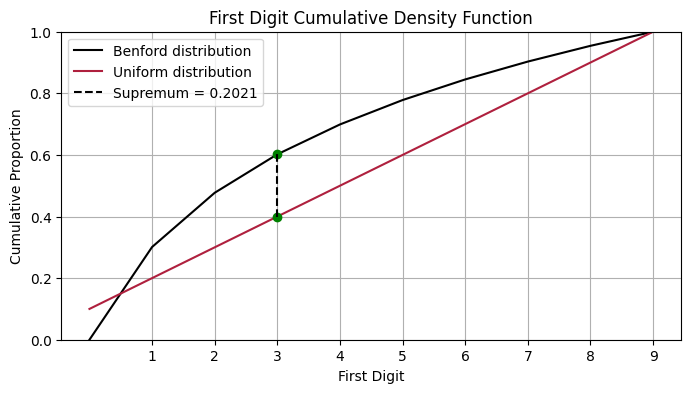

In [222]:
# Calculate cumulative proportions for Benford's law and Uniform distribution
benford_digits = list(benford_nth_digit_probabilities(1).keys())
benford_probs = list(benford_nth_digit_probabilities(1).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

uni_digits = benford_digits  # Ensure the digits align with Benford's digits
uni_probs = [0.1] * len(uni_digits)  # Uniform probabilities for digits 1 through 9
uni_cumulative = [sum(uni_probs[:i+1]) for i in range(len(uni_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, uni_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_uni = uni_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford distribution')
ax.plot(uni_digits, uni_cumulative, color="#af203e", label='Uniform distribution')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_uni], 'go')  # Point on Uniform curve
ax.vlines(supremum_x, supremum_y_uni, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(1, 10))



# Add title, labels, and legend
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
plt.show()


In [173]:
#calculate the ks statistic for the uniform_first_digit
n=1000
calculate_ks_statistic(uniform_first_digit, list(benford_nth_digit_probabilities(1).values())[1:],n)




KS statistic: 0.1899
Alpha=0.001: Reject null hypothesis (KS=0.1899 > Critical=0.0617)
Alpha=0.010: Reject null hypothesis (KS=0.1899 > Critical=0.0515)
Alpha=0.050: Reject null hypothesis (KS=0.1899 > Critical=0.0430)


{'KS_statistic': 0.1899188845528701,
 'Results': {0.001: 'Reject null hypothesis (KS=0.1899 > Critical=0.0617)',
  0.01: 'Reject null hypothesis (KS=0.1899 > Critical=0.0515)',
  0.05: 'Reject null hypothesis (KS=0.1899 > Critical=0.0430)'}}

### Fibonacci sequence

In [33]:
def fibonacci(n):
    a, b = 1, 1
    for _ in range(n):
        yield a
        a, b = b, a + b


In [34]:
fib = list(fibonacci(10000))
fcount=data_digit_probabilities(fib, 1)

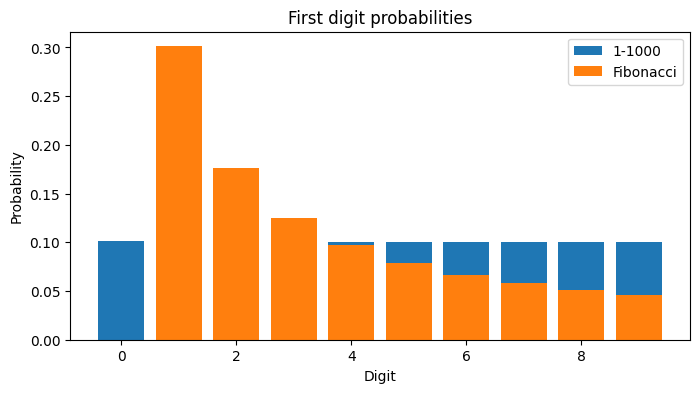

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(first_digit_probabilities_for_numbers.keys(), first_digit_probabilities_for_numbers.values(), label='1-1000')
ax.bar(fcount.keys(), fcount.values(), label='Fibonacci')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

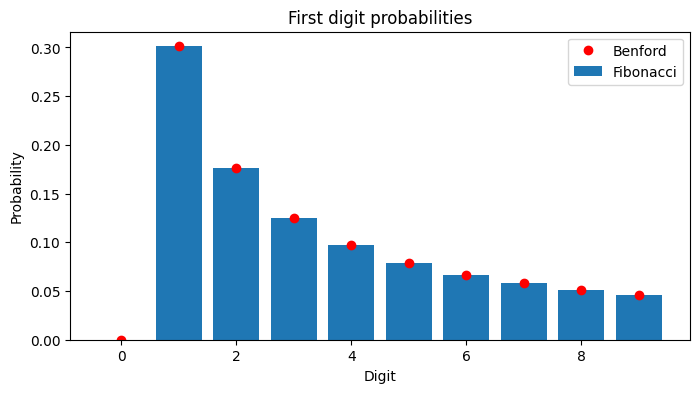

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ro', label='Benford')
ax.bar(fcount.keys(), fcount.values(), label='Fibonacci')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


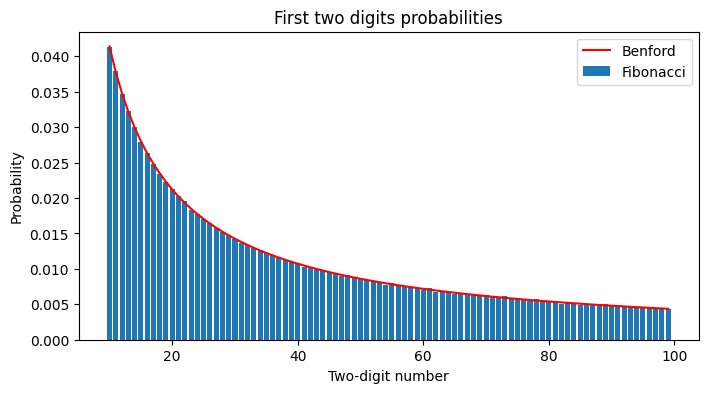

In [37]:
#plot in a graph Benford's first two digits probabilities as a red circle and the Fibonacci sequence as a bar chart
#For first two digits so use the function Benford_theory_firsttwo_digits and data_digit_probabilities_firsttwo
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'r', label='Benford')
ax.bar(data_digit_probabilities_firsttwo(fib).keys(), data_digit_probabilities_firsttwo(fib).values(), label='Fibonacci')
ax.set_title('First two digits probabilities')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Probability')
ax.legend()
plt.show()



In [38]:
#create a table with this columns: first digit, Benford's probabilities, Fibonacci's sequence probabilities, Difference
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Fibonacci\'s sequence probabilities'] = data_digit_probabilities(fib, 1).values()
Benford_theory['Difference'] = Benford_theory['Fibonacci\'s sequence probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,First digit,Benford probabilities,Fibonacci's sequence probabilities,Difference
0,0,0.000000,0.0000,0.000000
1,1,0.301030,0.3011,0.000070
2,2,0.176091,0.1762,0.000109
3,3,0.124939,0.1250,0.000061
4,4,0.096910,0.0968,-0.000110
5,5,0.079181,0.0792,0.000019
6,6,0.066947,0.0668,-0.000147
7,7,0.057992,0.0580,0.000008
8,8,0.051153,0.0513,0.000147
9,9,0.045757,0.0456,-0.000157


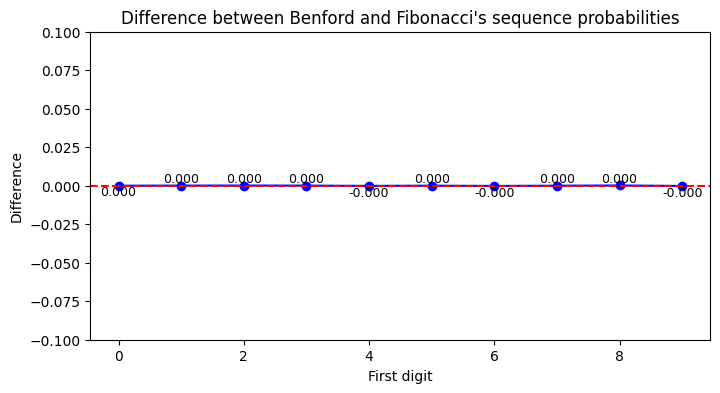

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'bo-')
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Difference between Benford and Fibonacci\'s sequence probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)
plt.show()


In [40]:
#create a table with this columns: first digit, Benford's probabilities, Election data 2018 probabilities, Difference
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities_gen(6,1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Fibonacci\'s sequence probabilities'] = data_digit_probabilities_gen(fib, 6,1).values()
Benford_theory['Difference'] = Benford_theory['Fibonacci\'s sequence probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,First digit,Benford probabilities,Fibonacci's sequence probabilities,Difference
0,0,0.000000,0.000000,0.000000
1,1,0.386853,0.386869,0.000016
2,2,0.226294,0.226391,0.000096
3,3,0.160558,0.160606,0.000048
4,4,0.124539,0.124374,-0.000165
5,5,0.101756,0.101760,0.000005


#### Fibonacci's tests

##### Z-Statistic

In [41]:
benford_nth_digit_probabilities(1).values()

dict_values([0, 0.3010299956639812, 0.17609125905568124, 0.12493873660829993, 0.09691001300805642, 0.07918124604762482, 0.06694678963061322, 0.05799194697768673, 0.05115252244738129, 0.04575749056067514])

In [42]:
#count the number of rows in Fibonacci dataset
len(fib)

10000

In [43]:
BP=Benford_theory_firsttwo_digits().values()
BP

dict_values([0.04139268515822508, 0.037788560889399754, 0.03476210625921191, 0.032184683371401235, 0.029963223377443202, 0.028028723600243534, 0.02632893872234915, 0.024823583725032145, 0.0234810958495229, 0.022276394711152208, 0.021189299069938092, 0.02020338608828699, 0.019305155195386624, 0.018483405694013133, 0.017728766960431616, 0.01703333929878037, 0.016390416188169384, 0.015794267183231885, 0.015239966556736905, 0.014723256820706378, 0.014240439114610285, 0.013788284485633285, 0.013363961557981502, 0.012964977164367635, 0.012589127308020467, 0.012234456417011586, 0.01189922329970769, 0.011581872549815138, 0.011281010409689084, 0.010995384301463145, 0.010723865391773066, 0.010465433678164979, 0.010219165181686028, 0.009984220906600923, 0.00975983728915624, 0.009545317906230361, 0.009340026254143432, 0.009143379439869719, 0.008954842652926412, 0.008773924307505152, 0.00860017176191757, 0.008433167536862764, 0.008272525965989857, 0.00811789022217946, 0.007968929671275373, 0.007825

In [44]:
data_digit_probabilities_firsttwo(fib).values()

dict_values([0.041324794876926155, 0.03792275365219131, 0.0347208324994997, 0.03221933159895938, 0.03001801080648389, 0.02791675005003002, 0.026415849509705824, 0.024814888933360015, 0.023414048429057435, 0.02231338803281969, 0.021212727636581948, 0.02021212727636582, 0.01951170702421453, 0.018310986591955174, 0.017710626375825496, 0.017010206123674206, 0.01650990594356614, 0.015709425655393235, 0.015209125475285171, 0.014808885331198719, 0.01420852511506904, 0.013708224934960976, 0.013307984790874524, 0.013007804682809685, 0.012707624574744846, 0.012307384430658395, 0.011907144286571943, 0.01150690414248549, 0.011306784070442265, 0.011006603962377426, 0.010806483890334201, 0.010306183710226135, 0.010206123674204523, 0.010006003602161296, 0.00980588353011807, 0.009605763458074845, 0.009305583350010006, 0.009005403241945167, 0.00910546327796678, 0.008705223133880328, 0.008605163097858715, 0.00840504302581549, 0.008304982989793876, 0.008204922953772264, 0.007704622773664198, 0.0080048028

Z-statistic value: [0.008981213073770691, 0.04415290947606669, 0.022532210945683112, 0.019631801630377053, 0.0028081091460133616, 0.03754723838281626, 0.023053161953436034, 0.005588372488570959, 0.011257946091530253, 0.02506644967242215, 0.016268146309918553, 0.006212843529005649, 0.11377701890798333, 0.090888590486628, 0.013746631798562055, 0.01787787730583541, 0.05472860979913503, 0.027945025201288456, 0.02517516839042453, 0.02958125578140306, 0.02693605839015781, 0.025777588594058876, 0.005204994046177219, 0.03785914059324596, 0.061436501490997324, 0.0208567750065256, 0.007304985622069244, 0.023336251632586912, 0.024404261508505054, 0.010759085677020714, 0.03166864803717281, 0.1073562216997882, 0.012967330059567628, 0.02190955075907545, 0.04683846186688767, 0.010742834512626842, 0.0358066265074863, 0.09242860744857424, 0.10680985102145406, 0.020053286631380517, 0.005405536681795845, 0.030755912808444173, 0.03583384841075464, 0.04126996797590352, 0.24103133993662262, 0.14692916517042

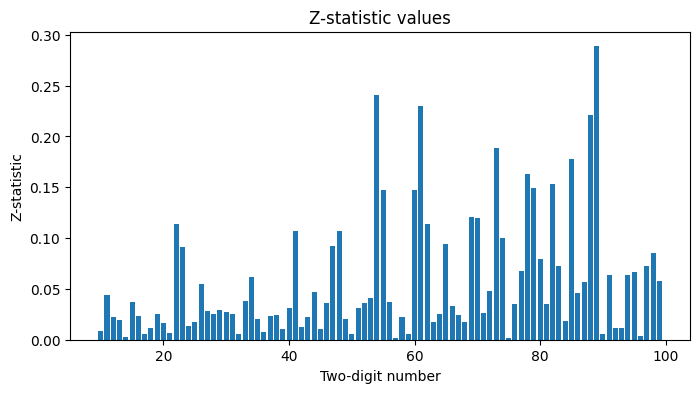

Maximum Z-statistic value: 0.2886128233750828 for the two-digit number 89


In [45]:

BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(fib).values())
N=len(fib)

# Calculate the Z-statistic, I want to pass two list of dictionaries keys
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")

#plot the z-statistic values in a bar chart, with in the x axis numbers from 10 to 99 and in the y axis the z-statistic values
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(data_digit_probabilities_firsttwo(fib).keys(), z_value)
ax.set_title('Z-statistic values')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Z-statistic')
plt.show()

#print the maximum z-statistic value with the corresponding two-digit number
max_z_value = max(z_value)
max_z_index = z_value.index(max_z_value)
max_two_digit_number = list(data_digit_probabilities_firsttwo(fib).keys())[max_z_index]
print(f"Maximum Z-statistic value: {max_z_value} for the two-digit number {max_two_digit_number}")



In [46]:
#create a table with this columns: two-digit number, Benford's probabilities, Fibonacci's sequence probabilities, Z-statistic
Benford_theory = pd.DataFrame(Benford_theory_firsttwo_digits().items(), columns=['Two-digit number', 'Benford probabilities'])
Benford_theory['Fibonacci\'s sequence probabilities'] = data_digit_probabilities_firsttwo(fib).values()
Benford_theory['Z-statistic'] = z_value
Benford_theory = Benford_theory.round(3)
Benford_theory


,Two-digit number,Benford probabilities,Fibonacci's sequence probabilities,Z-statistic
0,10,0.041,0.041,0.009
1,11,0.038,0.038,0.044
2,12,0.035,0.035,0.023
3,13,0.032,0.032,0.020
4,14,0.030,0.030,0.003
...,...,...,...,...
85,95,0.005,0.005,0.067
86,96,0.005,0.005,0.003
87,97,0.004,0.005,0.073
88,98,0.004,0.004,0.085


In [47]:
#calculate the z-statistic with the function above for the first position, keep only the pnumbers that come from benford_nth_digit_probabilities(1) and data_digit_probabilities(fib, 1) from index 1 to 9, so remove
#the first element of the list
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(fib, 1).values())[1:]
N=len(fib)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")


Z-statistic value: [0.0043610391489410085, 0.015421707774531125, 0.0034064451700796168, 0.020285959596438218, 0.006945356857096474, 0.03872672297147046, 0.0034454642642853446, 0.04424588495235024, 0.05144105288118391]


In [48]:
#calculate the z-statistic with the function above for the second position
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(fib, 2).values())
N=len(fib)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")


Z-statistic value: [0.013122718437104974, 0.006856764601970792, 0.06626522130524795, 0.12538863053695382, 0.032657384099614425, 0.023450719479139685, 0.04516061146635051, 0.05158854419122653, 0.006198799493503905, 0.0013190584812195854]


##### MAD

In [49]:
#apply the function calculate_mad to the first position
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(fib, 1).values())[1:]
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Mean Absolute Deviation (MAD) from Benford's Law: 9.206515540995108e-05


In [50]:
#apply the function calculate_mad to the second position of the Fibonacci sequence
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(fib, 2).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Mean Absolute Deviation (MAD) from Benford's Law: 0.00015219369250198816


In [51]:
#apply the function calculate_mad to the firsttwo position of the Fibonacci sequence
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(fib).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Mean Absolute Deviation (MAD) from Benford's Law: 8.210617381083443e-05


##### Chi-square test

In [52]:
#apply the chi square to the first position of the Fibonacci sequence
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(fib, 1).values())[1:]
N=len(fib)
calculate_chi_square(AP, BP, N)


N:  10000
Chi-Square statistic: 0.0153
p-value: 1.0000
Critical value at alpha=0.1%: 26.1245
Fail to reject null hypothesis at alpha=0.1%
Critical value at alpha=1.0%: 20.0902
Fail to reject null hypothesis at alpha=1.0%
Critical value at alpha=5.0%: 15.5073
Fail to reject null hypothesis at alpha=5.0%


In [53]:
#apply the chi square to the second position of the Fibonacci sequence
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(fib, 2).values())
N=len(fib)
calculate_chi_square(AP, BP, N)


N:  10000
Chi-Square statistic: 0.0367
p-value: 1.0000
Critical value at alpha=0.1%: 27.8772
Fail to reject null hypothesis at alpha=0.1%
Critical value at alpha=1.0%: 21.6660
Fail to reject null hypothesis at alpha=1.0%
Critical value at alpha=5.0%: 16.9190
Fail to reject null hypothesis at alpha=5.0%


In [54]:
len(fib)

10000

In [55]:
#apply the chi square to the firsttwo position of the Fibonacci sequence
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(fib).values())
N=len(fib)
calculate_chi_square(AP, BP, N)


N:  10000
Chi-Square statistic: 1.3222
p-value: 1.0000
Critical value at alpha=0.1%: 135.9776
Fail to reject null hypothesis at alpha=0.1%
Critical value at alpha=1.0%: 122.9422
Fail to reject null hypothesis at alpha=1.0%
Critical value at alpha=5.0%: 112.0220
Fail to reject null hypothesis at alpha=5.0%


##### FSD mean

In [56]:
#calculate also fsd mean of a Benford distribution
calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9)

3.440236967123206

In [57]:
#apply the function calculate_fsd_mean to calculate the mean of the first significant digit for the first position of the Fibonacci sequence
calculate_fsd_mean(list(data_digit_probabilities(fib, 1).values())[1:], start_digit=1, num_digits=9)



3.4393000000000002

In [58]:
#calculate fsd mean of a Benford distribution for the second position
calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10)

4.1873897069289425

In [59]:
#calculate fsd mean of the second position of the Fibonacci sequence
calculate_fsd_mean(list(data_digit_probabilities(fib, 2).values()), start_digit=0, num_digits=10)

4.187012207324394

In [60]:
#calculate fsd mean of a Benford distribution for the first two digits
calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90)

38.589759378161006

In [61]:
#calculate fsd mean of the first two digits of the Fibonacci sequence
calculate_fsd_mean(list(data_digit_probabilities_firsttwo(fib).values()), start_digit=10, num_digits=90)

38.58064838903343

##### Kolmogorov-Smirnov test

In [153]:
benford_nth_digit_probabilities(1).keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

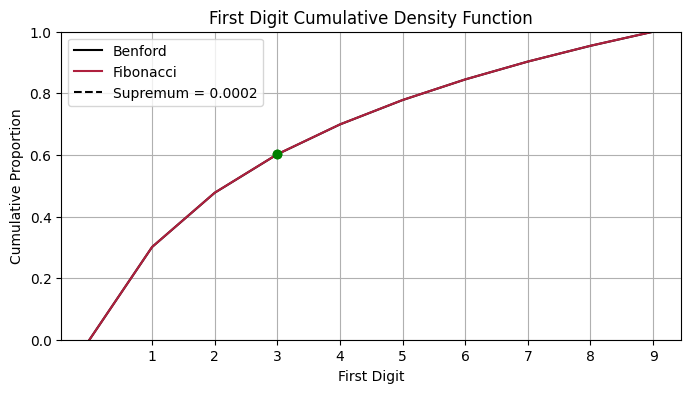

(0.0002400086720375505, 3)

In [221]:
# Calculate cumulative proportions for Benford's law and Fibonacci sequence
benford_digits = list(benford_nth_digit_probabilities(1).keys())
benford_probs = list(benford_nth_digit_probabilities(1).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

fib_digits = list(data_digit_probabilities(fib, 1).keys())
fib_probs = list(data_digit_probabilities(fib, 1).values())
fib_cumulative = [sum(fib_probs[:i+1]) for i in range(len(fib_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - f) for b, f in zip(benford_cumulative, fib_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_fib = fib_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford')
ax.plot(fib_digits, fib_cumulative, color="#af203e", label='Fibonacci')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_fib], 'go')  # Point on Fibonacci curve
ax.vlines(supremum_x, supremum_y_fib, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(1, 10))

# Add title, labels, and legend
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
plt.show()

supremum, supremum_x




In [143]:
#calculate the ks statistic for the first position of the Fibonacci sequence
N=len(fib)
calculate_ks_statistic(list(data_digit_probabilities(fib, 1).values())[1:], list(benford_nth_digit_probabilities(1).values())[1:],N)



KS statistic: 0.0002
Alpha=0.001: Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0195)
Alpha=0.010: Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0163)
Alpha=0.050: Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0136)


{'KS_statistic': 0.00015749056067514144,
 'Results': {0.001: 'Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0195)',
  0.01: 'Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0163)',
  0.05: 'Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0136)'}}

### 2018 Italian elections

#### Data cleaning and preparation

In this cell, we select only the columns that we need for the analysis. We don't have the data for the polling stations so we use the aggregation for comune.

In [62]:
file_path = "C:/Users/franc/Desktop/Tesi/Benford/Codice/Dati/Camera2018_livComune.txt"
election_data_18 = pd.read_csv(file_path, sep=";", encoding='latin1')
election_data_18 = election_data_18[['COMUNE','VOTANTI', 'LISTA', 'COGNOME', 'NOME', 'VOTI_LISTA']]
election_data_18



,COMUNE,VOTANTI,LISTA,COGNOME,NOME,VOTI_LISTA
0,TORINO,124770,CASAPOUND ITALIA,ARNONE,GINO MICHELE DOMENICO,972.0
1,TORINO,124770,IL POPOLO DELLA FAMIGLIA,COLUCCI,VITANTONIO,765.0
2,TORINO,124770,NOI CON L'ITALIA - UDC,FRANCIA,MARCO,743.0
3,TORINO,124770,LEGA,FRANCIA,MARCO,15783.0
4,TORINO,124770,FORZA ITALIA,FRANCIA,MARCO,15055.0
...,...,...,...,...,...,...
133819,VILLENEUVE,705,POUR TOUS PER TUTTI PE TCHEUT,MARCOZ,GIAMPAOLO,NaN
133820,VILLENEUVE,705,FI -FRAT. D'IT. -MOV.NUOVA VALLE D'AOSTA,MELGARA,EDOARDO,NaN
133821,VILLENEUVE,705,RISPOSTA CIVICA,MINELLI,CHIARA,NaN
133822,VILLENEUVE,705,POTERE AL POPOLO!,RAPPAZZO,FRANCESCO,NaN


In [63]:
#show me the highest and lowest value of "VOTANTI" with all the row
election_data_18.loc[election_data_18['VOTANTI'].idxmax()]
election_data_18.loc[election_data_18['VOTANTI'].idxmin()]


COMUNE                  MONCENISIO
VOTANTI                         24
LISTA         PARTITO VALORE UMANO
COGNOME                    CARELLA
NOME                       CLAUDIA
VOTI_LISTA                     0.0
Name: 3820, dtype: object

Here we remove all the municipalities with the same name. This are CALLIANO, CASTRO, LIVO, PEGLIO, SAMONE, SAN TEODORO and VALVERDE.


In [64]:
#remove from the dataset the rows with COMUNE == ["CALLIANO", "CASTRO", "LIVO", "PEGLIO", "SAMONE", "SAN TEODORO", "VALVERDE"]
election_data_18 = election_data_18[~election_data_18['COMUNE'].isin(["CALLIANO", "CASTRO", "LIVO", "PEGLIO", "SAMONE", "SAN TEODORO", "VALVERDE"])]

In [65]:
#show me the column with the same name of COMUNE, bigger than 18. FOr example, if I have 18 columns with COMUNE=="CASIER" I don't want to show "CASIER", 
# if instead I have 100 column with COMUNE=="TORINO" I want to show "TORINO"
# I want to do it for all the variables in COMUNE
election_data_18.groupby('COMUNE').filter(lambda x: x.shape[0] > 25)['COMUNE'].unique()


array(['TORINO', 'MILANO', 'GENOVA', 'BOLOGNA', 'FIRENZE', 'ROMA',
       'NAPOLI', 'BARI', 'PALERMO'], dtype=object)

In the next cell, we group the data by comune and we sum the votes for each party, without taking into consideration the different candidates. Due to the electoral law (Rosatellum bis), the voters can't write the preference for the candidate, that are elected in the order of the blocked list, but can choose only the party. So we will consider only the votes for the party, for each comune.

In [66]:
#group by comune and lista and sum the VOTI_LISTA
election_18_grouped = election_data_18.groupby(['COMUNE', 'LISTA'])['VOTI_LISTA'].sum().reset_index()
election_18_grouped


,COMUNE,LISTA,VOTI_LISTA
0,ABANO TERME,+EUROPA,343.0
1,ABANO TERME,10 VOLTE MEGLIO,47.0
2,ABANO TERME,CASAPOUND ITALIA,72.0
3,ABANO TERME,CIVICA POPOLARE LORENZIN,48.0
4,ABANO TERME,FORZA ITALIA,1408.0
...,...,...,...
133112,ZUNGRI,PARTITO COMUNISTA,2.0
133113,ZUNGRI,PARTITO DEMOCRATICO,165.0
133114,ZUNGRI,PARTITO VALORE UMANO,1.0
133115,ZUNGRI,PER UNA SINISTRA RIVOLUZIONARIA,1.0


In order to apply the Benford's law, we need to consider the first significant digit of the votes. For doing this, we have to removes all the parties that has zero votes.

In [67]:
#count the values of VOTI_LISTA equal to 1
election_18_grouped[election_18_grouped['VOTI_LISTA'] == 0].shape[0]

11158

In [68]:
election_18_grouped = election_18_grouped[election_18_grouped['VOTI_LISTA'] != 0].reset_index(drop=True)
election_18_grouped['VOTI_LISTA'] = election_18_grouped['VOTI_LISTA'].astype(int)
print(election_18_grouped)


             COMUNE                            LISTA  VOTI_LISTA
0       ABANO TERME                          +EUROPA         343
1       ABANO TERME                  10 VOLTE MEGLIO          47
2       ABANO TERME                 CASAPOUND ITALIA          72
3       ABANO TERME         CIVICA POPOLARE LORENZIN          48
4       ABANO TERME                     FORZA ITALIA        1408
...             ...                              ...         ...
121954       ZUNGRI                PARTITO COMUNISTA           2
121955       ZUNGRI              PARTITO DEMOCRATICO         165
121956       ZUNGRI             PARTITO VALORE UMANO           1
121957       ZUNGRI  PER UNA SINISTRA RIVOLUZIONARIA           1
121958       ZUNGRI                POTERE AL POPOLO!           2

[121959 rows x 3 columns]


In [69]:
#count the values of VOTI_LISTA equal to 1
election_18_grouped[election_18_grouped['VOTI_LISTA'] == 1].shape[0]


8609

In [70]:
#print the list of LISTA and the number of unique values
election_18_grouped['LISTA'].unique()
#election_18_grouped['LISTA'].nunique()

array(['+EUROPA', '10 VOLTE MEGLIO', 'CASAPOUND ITALIA',
       'CIVICA POPOLARE LORENZIN', 'FORZA ITALIA',
       "FRATELLI D'ITALIA CON GIORGIA MELONI", 'GRANDE NORD',
       'IL POPOLO DELLA FAMIGLIA', 'ITALIA AGLI ITALIANI',
       'ITALIA EUROPA INSIEME', 'LEGA', 'LIBERI E UGUALI',
       'MOVIMENTO 5 STELLE', "NOI CON L'ITALIA - UDC",
       'PARTITO DEMOCRATICO', 'PARTITO REPUBBLICANO ITALIANO - ALA',
       'PARTITO VALORE UMANO', 'POTERE AL POPOLO!',
       'PER UNA SINISTRA RIVOLUZIONARIA', 'PARTITO COMUNISTA',
       'AUTODETERMINATZIONE', "BLOCCO NAZIONALE PER LE LIBERTA'",
       'LISTA DEL POPOLO PER LA COSTITUZIONE', 'ITALIA NEL CUORE',
       "PATTO PER L'AUTONOMIA", 'SIAMO', 'SVP - PATT', 'RINASCIMENTO MIR'],
      dtype=object)

In [71]:
#count the number of column with COMUNE == 'ROMA' and give me a number
election_18_grouped[election_18_grouped['COMUNE'] == 'ROMA'].shape[0]

19

In [72]:
election_18_grouped.loc[election_18_grouped['VOTI_LISTA'].idxmax()]
#election_data_18.loc[election_data_18['VOTANTI'].idxmin()]

COMUNE                      ROMA
LISTA         MOVIMENTO 5 STELLE
VOTI_LISTA                423382
Name: 88897, dtype: object

In [73]:
#compute general statistics like mean, median, std, min, max, qqplot, quantiles, skewness for the VOTI_LISTA
election_18_grouped['VOTI_LISTA'].describe()

#save it in a table that I can use in a LaTeX document
#election_18_grouped['VOTI_LISTA'].describe().to_latex('election_data_18_statistics.tex', float_format="%.3f")


count    121959.000000
mean        258.852065
std        2393.420465
min           1.000000
25%           6.000000
50%          22.000000
75%         110.000000
max      423382.000000
Name: VOTI_LISTA, dtype: float64

#### First digit analysis

The first digit test compares the actual first digit frequency distribution of data that come from the italian election
with that developed by Benford.
It is an extremely high-level test and will only identify obvious anomalies (i.e., it will only point
you in the right direction)

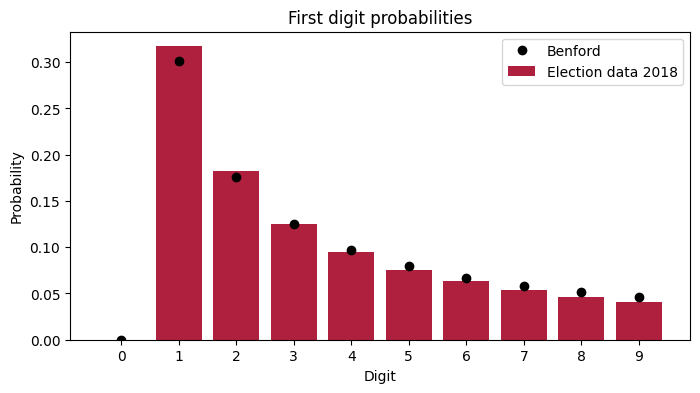

In [74]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values(), label='Election data 2018', color='#af203e')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.xticks(range(10))
plt.show()


In [75]:
#create a table with this columns: first digit, Benford's probabilities, Election data 2018 probabilities, Difference
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

#write the result for a LaTeX table
#Benford_theory.to_latex('italy_first_digit.tex', float_format="%.3f")



,First digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.000000,0.000000,0.000000
1,1,0.301030,0.317074,0.016044
2,2,0.176091,0.182217,0.006126
3,3,0.124939,0.125624,0.000685
4,4,0.096910,0.095352,-0.001558
5,5,0.079181,0.075730,-0.003451
6,6,0.066947,0.063390,-0.003557
7,7,0.057992,0.054092,-0.003900
8,8,0.051153,0.045827,-0.005326
9,9,0.045757,0.040694,-0.005063


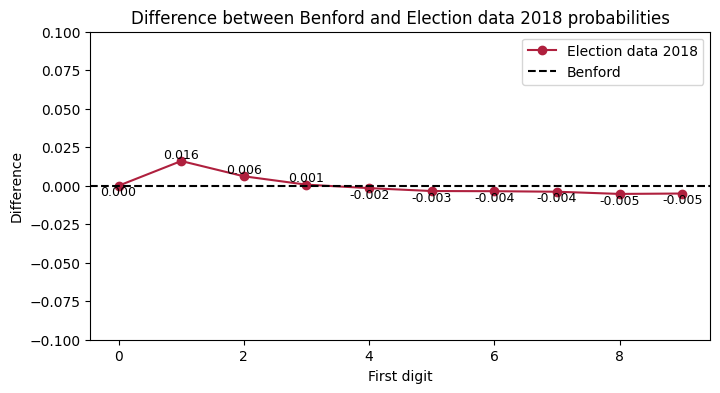

In [76]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'o-', color='#af203e')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

ax.legend(['Election data 2018', 'Benford'], loc='upper right')

plt.show()


##### Z-Statistic

In [77]:
#apply z-statistic to the election data 2018, first position
BP=list(benford_nth_digit_probabilities(1).values())[1:]
print(BP)
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
print(AP)
N=len(election_18_grouped)
print(N)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")
#print z-statistic values i for LaTeX table, with digits from 1 to 9, diffrences between percentages and z-statistic values
#write the result for a LaTeX table called z_statistic_18_first.tex
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#remove the index 0
Benford_theory = Benford_theory[1:]
Benford_theory['Z-statistic'] = z_value
Benford_theory.to_latex('z_statistic_18_first.tex', float_format="%.3f")



[0.3010299956639812, 0.17609125905568124, 0.12493873660829993, 0.09691001300805642, 0.07918124604762482, 0.06694678963061322, 0.05799194697768673, 0.05115252244738129, 0.04575749056067514]
[0.31707377069342974, 0.18221697455702326, 0.1256241851769857, 0.09535171656048344, 0.07573036840249592, 0.06339015570806583, 0.054091948933658034, 0.04582687624529555, 0.0406940037225625]
121959
Z-statistic value: [12.211481164429287, 5.612605783886533, 0.7196290015543682, 1.8346916015325403, 4.457814413263635, 4.9639466969032116, 5.821077572173993, 8.435543217728098, 8.45559858216933]


In [78]:
from scipy.stats import norm

def calculate_critical_value(alpha):
    """
    Calculate the critical Z-value for a given significance level (alpha).
    
    Parameters:
    - alpha: Significance level (e.g., 0.05 for 5%).
    
    Returns:
    - Z-critical value.
    """
    return norm.ppf(1 - alpha / 2)

# Define significance levels
significance_levels = {
    "0,1%": 0.001,
    "1%": 0.01,
    "5%": 0.05
}

# Calculate and store cutoff values
cutoff_values = {level: calculate_critical_value(alpha) for level, alpha in significance_levels.items()}

# Display cutoff values
print("Critical Z-values for different significance levels:")
for level, cutoff in cutoff_values.items():
    print(f"- {level} significance level: Z-critical = {cutoff:.3f}")

# Example usage with Z-values
z_values = z_value # Replace with your Z-statistics
print("\nInterpretation of Z-statistics at each significance level:")

for level, cutoff in cutoff_values.items():
    print(f"\nAt {level} significance level (cutoff = {cutoff:.3f}):")
    for i, z in enumerate(z_values):
        if abs(z) > cutoff:
            print(f"  Pair {i + 1}: |Z| = {abs(z):.3f} > {cutoff:.3f} (Significant, data does not follow Benford's Law, reject H0)")
        else:
            print(f"  Pair {i + 1}: |Z| = {abs(z):.3f} <= {cutoff:.3f} (Not Significant, data follows Benford's Law, fail to reject H0)")


Critical Z-values for different significance levels:
- 0,1% significance level: Z-critical = 3.291
- 1% significance level: Z-critical = 2.576
- 5% significance level: Z-critical = 1.960

Interpretation of Z-statistics at each significance level:

At 0,1% significance level (cutoff = 3.291):
  Pair 1: |Z| = 12.211 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 2: |Z| = 5.613 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 3: |Z| = 0.720 <= 3.291 (Not Significant, data follows Benford's Law, fail to reject H0)
  Pair 4: |Z| = 1.835 <= 3.291 (Not Significant, data follows Benford's Law, fail to reject H0)
  Pair 5: |Z| = 4.458 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 6: |Z| = 4.964 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 7: |Z| = 5.821 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 8: |Z| = 8.436 > 3.291 (Significant, data does not f

##### MAD

In [79]:
#apply MAD function to the election data, first position
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Mean Absolute Deviation (MAD) from Benford's Law: 0.005078875355439187


##### Chi-square test

In [80]:
#apply chi square to the election data, first position
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
N=len(election_18_grouped)
calculate_chi_square(AP, BP, N)

N:  121959
Chi-Square statistic: 343.1198
p-value: 0.0000
Critical value at alpha=0.1%: 26.1245
Reject null hypothesis at alpha=0.1%
Critical value at alpha=1.0%: 20.0902
Reject null hypothesis at alpha=1.0%
Critical value at alpha=5.0%: 15.5073
Reject null hypothesis at alpha=5.0%


The data suggest a significant difference between the observed and expected frequencies. This result confirms the strong deviation of the observed frequencies from the expected proportions, indicating that the theoretical model (expected distribution) does not fit well with the observed data.

##### FSD mean

In [81]:
#calculate fsd mean of a Benford distribution for the first position
calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9)

3.440236967123206

In [82]:
#calculate fsd mean of the first position of the election data
calculate_fsd_mean(list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:], start_digit=1, num_digits=9)

3.3102846038422755

##### Kolmogorov-Smirnov test

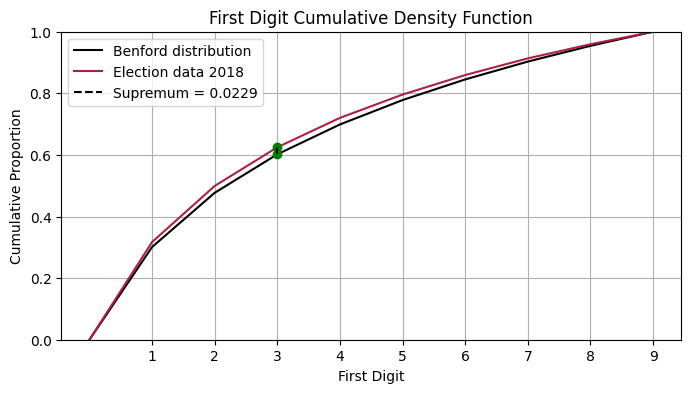

In [220]:
# Calculate cumulative proportions for Benford's law and first position of the election data
benford_digits = list(benford_nth_digit_probabilities(1).keys())
benford_probs = list(benford_nth_digit_probabilities(1).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).keys())
election_probs = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford distribution')
ax.plot(uni_digits, election_cumulative, color="#af203e", label='Election data 2018')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Election curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(1, 10))
# Add title, labels, and legend
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
plt.show()

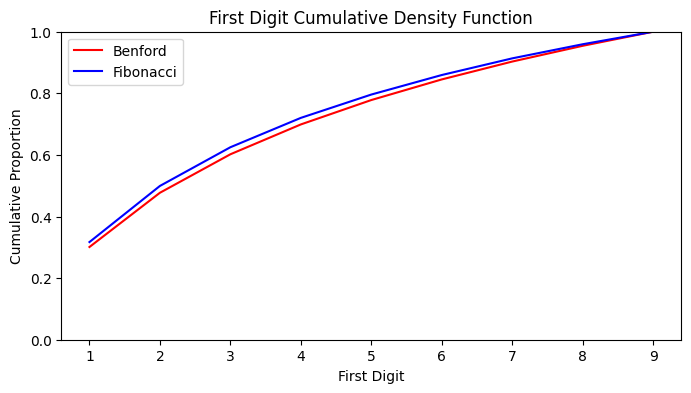

In [164]:
# Calculate cumulative proportions for Benford's law and Uniform distribution
benford_digits = list(benford_nth_digit_probabilities(1).keys())[1:]
benford_probs = list(benford_nth_digit_probabilities(1).values())[1:]
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_18_digits = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).keys())[1:]
election_18_probs = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
election_18_cumulative = [sum(election_18_probs[:i+1]) for i in range(len(election_18_probs))]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'r', label='Benford')
ax.plot(election_18_digits, election_18_cumulative, 'b', label='Fibonacci')
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
plt.show()


In [144]:
#calculate the ks statistic for the first position of the election data
N=len(election_18_grouped)
calculate_ks_statistic(list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:], list(benford_nth_digit_probabilities(1).values())[1:],N)


KS statistic: 0.0160
Alpha=0.001: Reject null hypothesis (KS=0.0160 > Critical=0.0056)
Alpha=0.010: Reject null hypothesis (KS=0.0160 > Critical=0.0047)
Alpha=0.050: Reject null hypothesis (KS=0.0160 > Critical=0.0039)


{'KS_statistic': 0.016043775029448537,
 'Results': {0.001: 'Reject null hypothesis (KS=0.0160 > Critical=0.0056)',
  0.01: 'Reject null hypothesis (KS=0.0160 > Critical=0.0047)',
  0.05: 'Reject null hypothesis (KS=0.0160 > Critical=0.0039)'}}

#### Second digit

We can do the same analysis that we have done for the first digit but for the second digit.

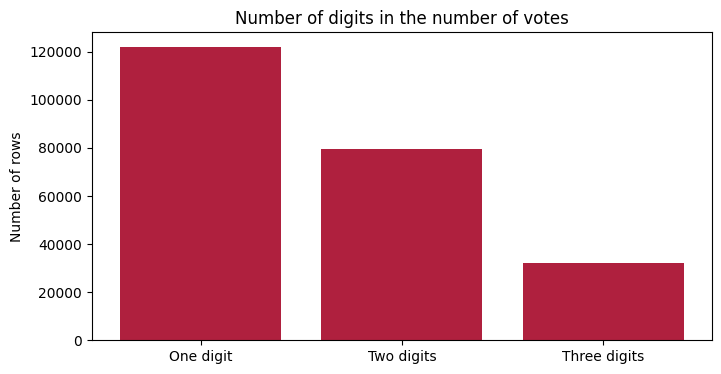

,digit,value,percentage,difference
0,One digit,121959,1.000000,0
1,Two digits,79576,0.652482,-42383
2,Three digits,32089,0.263113,-47487


In [83]:
#count the number of rows in election_18_grouped['VOTI_LISTA']
onep=election_18_grouped['VOTI_LISTA'].shape[0]

#count the number of rows in election_18_grouped['VOTI_LISTA'] with values bigger or equal to 10. In other words values that have 2 digits or more
twop=election_18_grouped[election_18_grouped['VOTI_LISTA'] >= 10].shape[0]

#count the number of rows in election_18_grouped['VOTI_LISTA'] with values bigger or equal to 100. In other words values that have 3 digits or more
threep=election_18_grouped[election_18_grouped['VOTI_LISTA'] >= 100].shape[0]

#plot in bar chart onep, twop, threep
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(['One digit', 'Two digits', 'Three digits'], [onep, twop, threep], color='#af203e')
ax.set_title('Number of digits in the number of votes')
ax.set_ylabel('Number of rows')
plt.show()

#visualize the number of onep, twop, threep
onep, twop, threep

#write the difference between the number of onep, twop, threep in a table with the value and the percentage and the values of onep, twop, threep
#I want a table with 4 columns: digit, value, percentage, difference
data = {'digit': ['One digit', 'Two digits', 'Three digits'],
        'value': [onep, twop, threep],
        'percentage': [onep/onep, twop/onep, threep/onep],
        'difference': [0, twop-onep, threep-twop]}

digits = pd.DataFrame(data)
digits



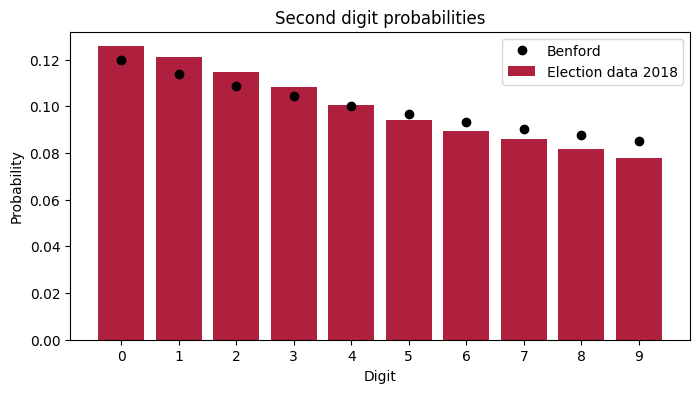

In [84]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values(), label='Election data 2018', color='#af203e')
ax.set_title('Second digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.xticks(range(10))

plt.show()


In [85]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(2).items(), columns=['Second digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

Benford_theory.to_latex('italy_second_digit.tex', float_format="%.3f")


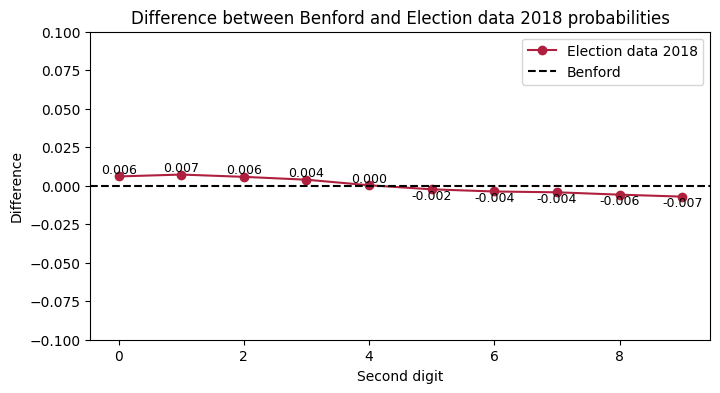

In [86]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['Second digit'], Benford_theory['Difference'], 'o-', color='#af203e')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('Second digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['Second digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)
ax.legend(['Election data 2018', 'Benford'], loc='upper right')

plt.show()


##### Z-Statistic

In [87]:
#apply z-statistic to the election data 2018, second position
BP=list(benford_nth_digit_probabilities(2).values())
print(BP)
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
print(AP)
N=twop
print(N)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")

#print z-statistic values i for LaTeX table, with digits from 1 to 9, diffrences between percentages and z-statistic values
#write the result for a LaTeX table called z_statistic_18_first.tex
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(2).items(), columns=['Second digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
Benford_theory['Z-statistic'] = z_value
Benford_theory.to_latex('z_statistic_18_second.tex', float_format="%.3f")

[0.11967926859688076, 0.1138901034075564, 0.10882149900550823, 0.10432956023095939, 0.10030820226757937, 0.09667723580232243, 0.09337473578303615, 0.09035198926960332, 0.08757005357886138, 0.08499735205769224]
[0.12570372976776917, 0.1211420528802654, 0.114582286116417, 0.10823615160349855, 0.1006082235850005, 0.0943374886900573, 0.08962501256660299, 0.08608123052176536, 0.08177088569417915, 0.07791293857444456]
79576
Z-statistic value: [5.230294507556986, 6.434022662324059, 5.212657998830932, 3.5992511757124497, 0.2758265741925618, 2.2274529159878265, 3.6293873212499745, 4.196151156179217, 5.781071692451876, 7.159714831299925]


In [88]:
# Example usage with Z-values
z_values = z_value # Replace with your Z-statistics
print("\nInterpretation of Z-statistics at each significance level:")

for level, cutoff in cutoff_values.items():
    print(f"\nAt {level} significance level (cutoff = {cutoff:.3f}):")
    for i, z in enumerate(z_values):
        if abs(z) > cutoff:
            print(f"  Pair {i + 1}: |Z| = {abs(z):.3f} > {cutoff:.3f} (Significant, data does not follow Benford's Law, reject H0)")
        else:
            print(f"  Pair {i + 1}: |Z| = {abs(z):.3f} <= {cutoff:.3f} (Not Significant, data follows Benford's Law, fail to reject H0)")


Interpretation of Z-statistics at each significance level:

At 0,1% significance level (cutoff = 3.291):
  Pair 1: |Z| = 5.230 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 2: |Z| = 6.434 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 3: |Z| = 5.213 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 4: |Z| = 3.599 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 5: |Z| = 0.276 <= 3.291 (Not Significant, data follows Benford's Law, fail to reject H0)
  Pair 6: |Z| = 2.227 <= 3.291 (Not Significant, data follows Benford's Law, fail to reject H0)
  Pair 7: |Z| = 3.629 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 8: |Z| = 4.196 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 9: |Z| = 5.781 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 10: |Z| = 7.160 > 3.291 (Significant, data does not follow

In [89]:
#Compute the chi-square test for the election data 2018, second digit
#It's not possible because we have 0 values in the Benford's Law

In [90]:
(election_18_grouped['VOTI_LISTA'], 2)

(0          343
 1           47
 2           72
 3           48
 4         1408
           ... 
 121954       2
 121955     165
 121956       1
 121957       1
 121958       2
 Name: VOTI_LISTA, Length: 121959, dtype: int32,
 2)

##### MAD


In [91]:
#apply MAD function to the election data, second position
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

#print AP, BP, K
AP, BP, K

Mean Absolute Deviation (MAD) from Benford's Law: 0.004648762088893263


([0.12570372976776917,
  0.1211420528802654,
  0.114582286116417,
  0.10823615160349855,
  0.1006082235850005,
  0.0943374886900573,
  0.08962501256660299,
  0.08608123052176536,
  0.08177088569417915,
  0.07791293857444456],
 [0.11967926859688076,
  0.1138901034075564,
  0.10882149900550823,
  0.10432956023095939,
  0.10030820226757937,
  0.09667723580232243,
  0.09337473578303615,
  0.09035198926960332,
  0.08757005357886138,
  0.08499735205769224],
 10)

##### Chi-square test

In [92]:
#apply chi square to the election data, second position
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
N=twop
calculate_chi_square(AP, BP, N)


N:  79576
Chi-Square statistic: 206.9584
p-value: 0.0000
Critical value at alpha=0.1%: 27.8772
Reject null hypothesis at alpha=0.1%
Critical value at alpha=1.0%: 21.6660
Reject null hypothesis at alpha=1.0%
Critical value at alpha=5.0%: 16.9190
Reject null hypothesis at alpha=5.0%


##### SSD mean

In [93]:
#calculate fsd mean of a Benford distribution for the second position
calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10)

4.1873897069289425

In [94]:
#calculate fsd mean of the second position of the election data
calculate_fsd_mean(list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values()), start_digit=0, num_digits=10)

4.044837639489293

##### Kolmogorov-Smirnov test


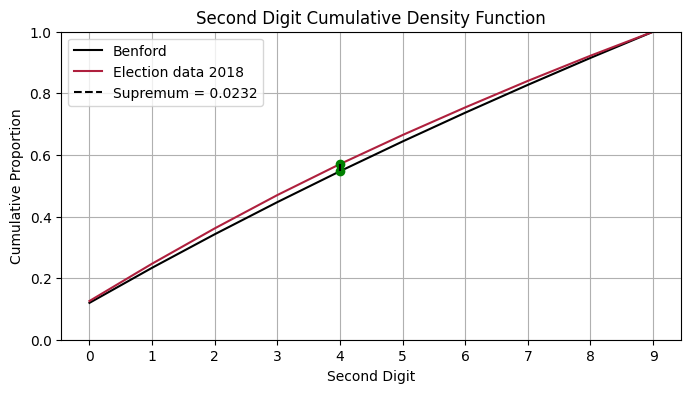

(4, 0.02324381044446644)

In [226]:
# Calculate cumulative proportions for Benford's law and second position of the election data
benford_digits = list(benford_nth_digit_probabilities(2).keys())
benford_probs = list(benford_nth_digit_probabilities(2).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).keys())
election_probs = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
election_cumulative = [sum(election_18_probs[:i+1]) for i in range(len(election_18_probs))]


# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford')
ax.plot(election_digits, election_cumulative, color="#af203e", label='Election data 2018')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Uniform curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(10))
# Add title, labels, and legend
ax.set_title('Second Digit Cumulative Density Function')
ax.set_xlabel('Second Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
plt.show()

supremum_x, supremum

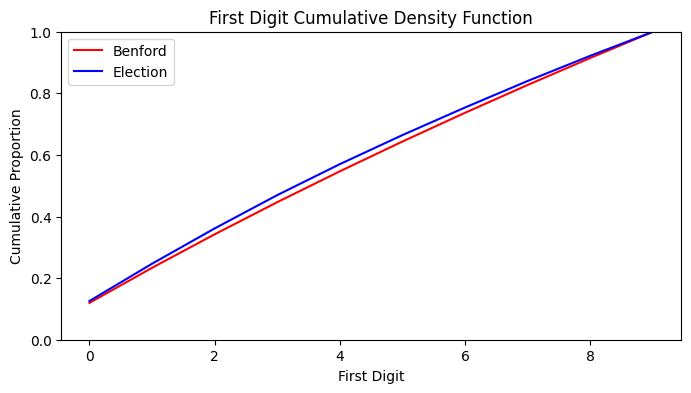

In [166]:
# Calculate cumulative proportions for Benford's law and Uniform distribution for the second position
benford_digits = list(benford_nth_digit_probabilities(2).keys())
benford_probs = list(benford_nth_digit_probabilities(2).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_18_digits = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).keys())
election_18_probs = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
election_18_cumulative = [sum(election_18_probs[:i+1]) for i in range(len(election_18_probs))]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'r', label='Benford')
ax.plot(election_18_digits, election_18_cumulative, 'b', label='Election')
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
plt.show()

In [148]:
#calculate the ks statistic for the second position of the election data
N=twop
print(N)
calculate_ks_statistic(list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values()), list(benford_nth_digit_probabilities(2).values()),N)


79576
KS statistic: 0.0073
Alpha=0.001: Reject null hypothesis (KS=0.0073 > Critical=0.0069)
Alpha=0.010: Reject null hypothesis (KS=0.0073 > Critical=0.0058)
Alpha=0.050: Reject null hypothesis (KS=0.0073 > Critical=0.0048)


{'KS_statistic': 0.0072519494727090045,
 'Results': {0.001: 'Reject null hypothesis (KS=0.0073 > Critical=0.0069)',
  0.01: 'Reject null hypothesis (KS=0.0073 > Critical=0.0058)',
  0.05: 'Reject null hypothesis (KS=0.0073 > Critical=0.0048)'}}

#### First-two digits

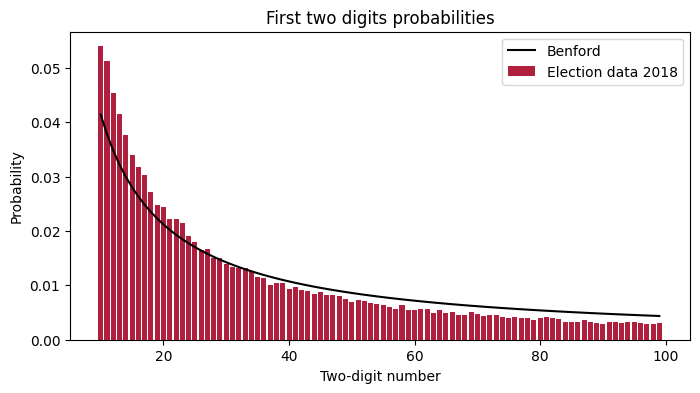

In [95]:
#use our dataset for the first two digits
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'black', label='Benford')
ax.bar(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).keys(), data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values(), label='Election data 2018',color='#af203e')
ax.set_title('First two digits probabilities')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


##### Z-Statistic

In [96]:
# Count rows with 'VOTI_LISTA' between 10 and 99
firsttwo = election_18_grouped[(election_18_grouped['VOTI_LISTA'] >= 10)].shape[0]
N = firsttwo

BP = list(Benford_theory_firsttwo_digits().values())
AP = list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
z_values = calculate_z_statistic(AP, BP, N)

Benford_theory = pd.DataFrame({
    'Two-digit number': range(10, 100),
    'Benford probabilities': BP,
    'Election data 2018 probabilities': AP,
    'Difference': [ap - bp for ap, bp in zip(AP, BP)],
    'Z-statistic': z_values
})

highest_5 = Benford_theory.nlargest(5, 'Z-statistic')
lowest_5 = Benford_theory.nsmallest(5, 'Z-statistic')
median_row = Benford_theory.iloc[[len(Benford_theory) // 2]]

final_table = pd.concat([highest_5, lowest_5, median_row]).drop_duplicates()

final_table.sort_values(by='Two-digit number').to_latex(
    'z_statistic_18_firsttwo.tex',
    index=False,
    float_format="%.3f"
)

N

79576

In [97]:
Benford_theory

,Two-digit number,Benford probabilities,Election data 2018 probabilities,Difference,Z-statistic
0,10,0.041393,0.053948,0.012556,17.771900
1,11,0.037789,0.051171,0.013383,19.788536
2,12,0.034762,0.045303,0.010540,16.222694
3,13,0.032185,0.041495,0.009310,14.870921
4,14,0.029963,0.037712,0.007749,12.811636
...,...,...,...,...,...
85,95,0.004548,0.003280,-0.001268,5.288862
86,96,0.004501,0.002991,-0.001510,6.335851
87,97,0.004454,0.002890,-0.001564,6.598778
88,98,0.004409,0.002915,-0.001494,6.332828


In [98]:
# Example usage with Z-values
z_values = Benford_theory["Z-statistic"] # Replace with your Z-statistics for the first two digits
print("\nInterpretation of Z-statistics at each significance level:")
for level, cutoff in cutoff_values.items():
    print(f"\nAt {level} significance level (cutoff = {cutoff:.3f}):")
    for i, z in enumerate(z_values):
        if abs(z) > cutoff:
            print(f"  Pair {i + 1}: |Z| = {abs(z):.3f} > {cutoff:.3f} (Significant, data does not follow Benford's Law, reject H0)")
        else:
            print(f"  Pair {i + 1}: |Z| = {abs(z):.3f} <= {cutoff:.3f} (Not Significant, data follows Benford's Law, fail to reject H0)")

#count how many not significant value we have when the significance level is 0.001
not_significant = sum(abs(z) <= cutoff_values["0,1%"] for z in z_values)
not_significant






Interpretation of Z-statistics at each significance level:

At 0,1% significance level (cutoff = 3.291):
  Pair 1: |Z| = 17.772 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 2: |Z| = 19.789 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 3: |Z| = 16.223 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 4: |Z| = 14.871 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 5: |Z| = 12.812 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 6: |Z| = 10.032 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 7: |Z| = 9.661 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 8: |Z| = 10.074 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 9: |Z| = 6.905 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 10: |Z| = 4.872 > 3.291 (Significant, data does not follow Be

22

##### MAD

In [99]:
#apply MAD function to the election data, first two digits
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

BP, AP, K

Mean Absolute Deviation (MAD) from Benford's Law: 0.0020463571360578464


([0.04139268515822508,
  0.037788560889399754,
  0.03476210625921191,
  0.032184683371401235,
  0.029963223377443202,
  0.028028723600243534,
  0.02632893872234915,
  0.024823583725032145,
  0.0234810958495229,
  0.022276394711152208,
  0.021189299069938092,
  0.02020338608828699,
  0.019305155195386624,
  0.018483405694013133,
  0.017728766960431616,
  0.01703333929878037,
  0.016390416188169384,
  0.015794267183231885,
  0.015239966556736905,
  0.014723256820706378,
  0.014240439114610285,
  0.013788284485633285,
  0.013363961557981502,
  0.012964977164367635,
  0.012589127308020467,
  0.012234456417011586,
  0.01189922329970769,
  0.011581872549815138,
  0.011281010409689084,
  0.010995384301463145,
  0.010723865391773066,
  0.010465433678164979,
  0.010219165181686028,
  0.009984220906600923,
  0.00975983728915624,
  0.009545317906230361,
  0.009340026254143432,
  0.009143379439869719,
  0.008954842652926412,
  0.008773924307505152,
  0.00860017176191757,
  0.008433167536862764,
  

##### Chi-square test


In [100]:
#apply chi square to the election data, first two digits
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
N=firsttwo
calculate_chi_square(AP, BP, N)


N:  79576
Chi-Square statistic: 3593.0064
p-value: 0.0000
Critical value at alpha=0.1%: 135.9776
Reject null hypothesis at alpha=0.1%
Critical value at alpha=1.0%: 122.9422
Reject null hypothesis at alpha=1.0%
Critical value at alpha=5.0%: 112.0220
Reject null hypothesis at alpha=5.0%


##### FTSD mean

In [101]:
#calculate fsd mean of a Benford distribution for the first two digits
calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90)

38.589759378161006

In [102]:
#calculate fsd mean of the first two digits of the election data
calculate_fsd_mean(list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values()), start_digit=10, num_digits=90)

33.58879561676888

##### Kolmogorov-Smirnov test

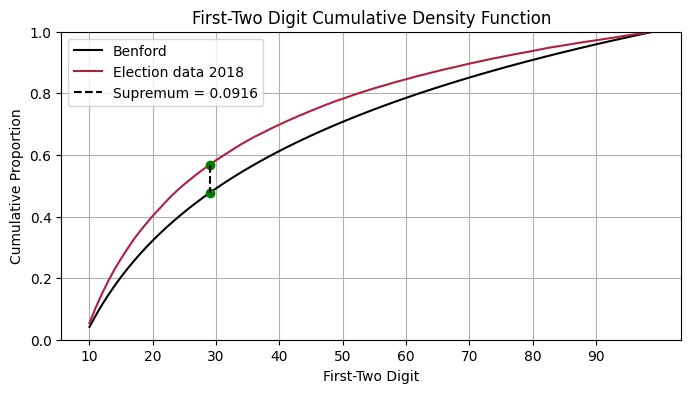

(29, 0.0916054970647951)

In [ ]:
# Calculate cumulative proportions for Benford's law and first-two position of the election data
benford_digits = list(Benford_theory_firsttwo_digits().keys())
benford_probs = list(Benford_theory_firsttwo_digits().values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).keys())
election_probs = list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford')
ax.plot(election_digits, election_cumulative, color='#af203e', label='Election data 2018')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Uniform curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

# Add title, labels, and legend
ax.set_title('First-Two Digit Cumulative Density Function')
ax.set_xlabel('First-Two Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
ax.set_xticks(range(10, 100,10))
plt.show()

#write the correspondent first two digits of the supremum
supremum_x, supremum



In [146]:
#calculate the ks statistic for the first two digits of the election data
N=firsttwo
calculate_ks_statistic(list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values()), list(Benford_theory_firsttwo_digits().values()),N)


KS statistic: 0.0134
Alpha=0.001: Reject null hypothesis (KS=0.0134 > Critical=0.0069)
Alpha=0.010: Reject null hypothesis (KS=0.0134 > Critical=0.0058)
Alpha=0.050: Reject null hypothesis (KS=0.0134 > Critical=0.0048)


{'KS_statistic': 0.01338264650981609,
 'Results': {0.001: 'Reject null hypothesis (KS=0.0134 > Critical=0.0069)',
  0.01: 'Reject null hypothesis (KS=0.0134 > Critical=0.0058)',
  0.05: 'Reject null hypothesis (KS=0.0134 > Critical=0.0048)'}}

#### Third digit

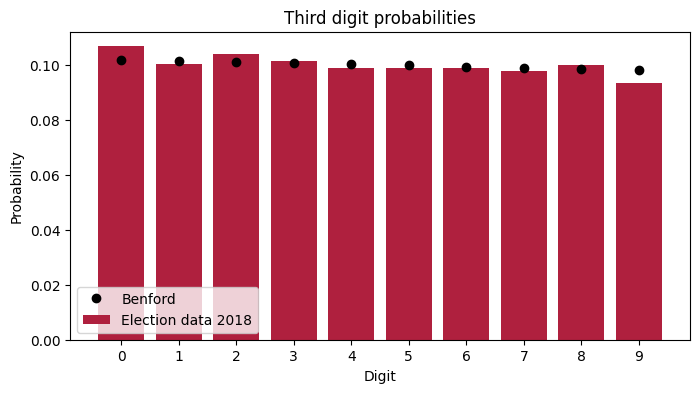

In [103]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(3).keys()), list(benford_nth_digit_probabilities(3).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).values(), label='Election data 2018', color='#af203e')
ax.set_title('Third digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()

plt.xticks(range(10))

plt.show()

In [104]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(3).items(), columns=['Second digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,Second digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.101784,0.106734,0.004950
1,1,0.101376,0.100284,-0.001092
2,2,0.100972,0.103930,0.002957
3,3,0.100573,0.101250,0.000677
4,4,0.100178,0.098975,-0.001203
5,5,0.099788,0.098975,-0.000813
6,6,0.099401,0.098694,-0.000707
7,7,0.099019,0.097822,-0.001198
8,8,0.098641,0.099816,0.001175
9,9,0.098267,0.093521,-0.004746


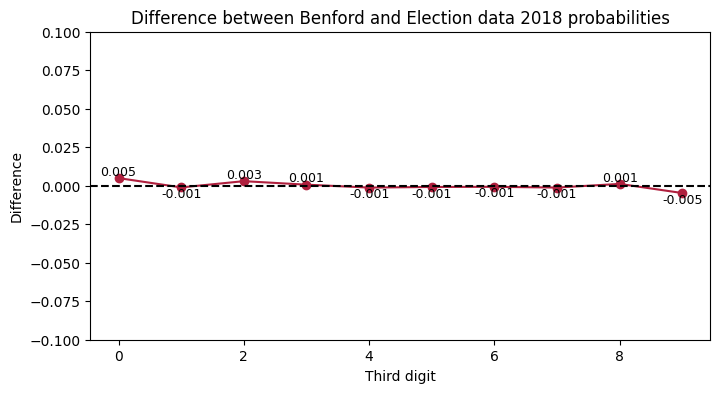

In [105]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['Second digit'], Benford_theory['Difference'], 'o-', color='#af203e')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('Third digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['Second digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

plt.show()

In [106]:
# Define the list of p_j as the probabilities of Benford_theory['Election data 2018 probabilities']
d= [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
p=list(benford_nth_digit_probabilities_gen(10, 3).values())

print(p)
# Compute the sum 
d_bar = sum(d[j] * p[j] for j in range(10))

# Print the result
print(d_bar)

[0.1017843646442167, 0.10137597744780127, 0.10097219813704164, 0.10057293211092619, 0.1001780876279476, 0.09978757569217742, 0.09940130994496177, 0.09901920656189599, 0.09864118415477718, 0.09826716367825328]
4.46776565097288


In [107]:
# Define the list of p_j as the probabilities of Benford_theory['Election data 2018 probabilities']
p=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).values())

print(p)
# Compute the sum 
d_bar = sum(d[j] * p[j] for j in range(10))

# Print the result
print(d_bar)

[0.10673439496400636, 0.10028358627567079, 0.10392969553429524, 0.10124964941257128, 0.0989747265418056, 0.0989747265418056, 0.09869425659883449, 0.09782168344292437, 0.09981613637071894, 0.09352114431736733]
4.419801177973761


#### Some corrections

We know that the Benford's law doesn't work for small numbers, so we can try to remove all the rows that has a number of votanti smaller than 1000.

In [108]:
#keep only rows with VOTANTI>1000 and voti_lista>0
election_data_18_small = election_data_18[(election_data_18['VOTANTI'] > 1000) & (election_data_18['VOTI_LISTA'] > 0)]
election_18_grouped_small = election_data_18_small.groupby(['COMUNE', 'LISTA'])['VOTI_LISTA'].sum().reset_index()
election_18_grouped_small

,COMUNE,LISTA,VOTI_LISTA
0,ABANO TERME,+EUROPA,343.0
1,ABANO TERME,10 VOLTE MEGLIO,47.0
2,ABANO TERME,CASAPOUND ITALIA,72.0
3,ABANO TERME,CIVICA POPOLARE LORENZIN,48.0
4,ABANO TERME,FORZA ITALIA,1408.0
...,...,...,...
80186,ZUNGRI,PARTITO COMUNISTA,2.0
80187,ZUNGRI,PARTITO DEMOCRATICO,165.0
80188,ZUNGRI,PARTITO VALORE UMANO,1.0
80189,ZUNGRI,PER UNA SINISTRA RIVOLUZIONARIA,1.0


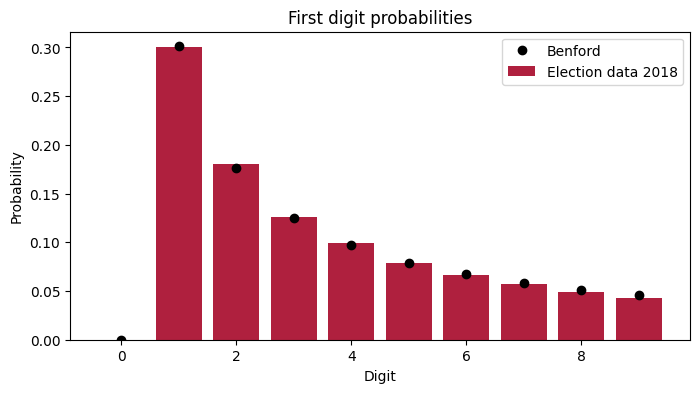

In [109]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped_small['VOTI_LISTA'], 1).keys(), data_digit_probabilities(election_18_grouped_small['VOTI_LISTA'], 1).values(), label='Election data 2018', color='#af203e')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

In [110]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped_small['VOTI_LISTA'], 1).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,First digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.000000,0.000000,0.000000
1,1,0.301030,0.300869,-0.000161
2,2,0.176091,0.180319,0.004228
3,3,0.124939,0.126161,0.001223
4,4,0.096910,0.098789,0.001879
5,5,0.079181,0.078301,-0.000881
6,6,0.066947,0.066628,-0.000318
7,7,0.057992,0.057188,-0.000803
8,8,0.051153,0.048684,-0.002469
9,9,0.045757,0.043060,-0.002698


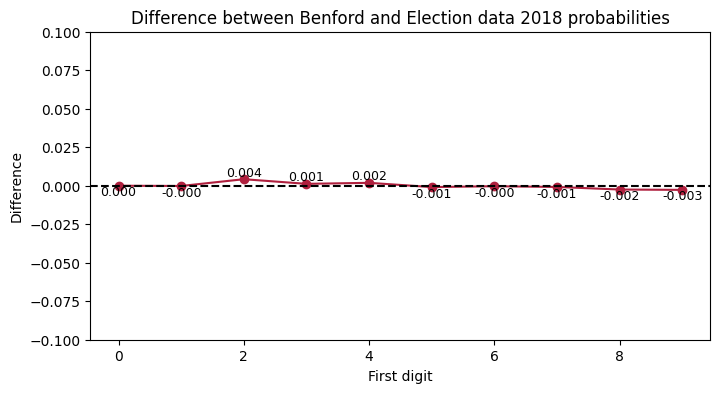

In [111]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'o-', color='#af203e')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

plt.show()


### Brexit referendum

In [112]:
#read the csv data of the brexit referendum
file_path = "C:/Users/franc/Desktop/Tesi/Benford/Codice/Dati/EU-referendum-result-data.csv"
brexit_data = pd.read_csv(file_path)
brexit_data
#show me the name of the variables
brexit_data.columns



Index(['id', 'Region_Code', 'Region', 'Area_Code', 'Area', 'Electorate',
       'ExpectedBallots', 'VerifiedBallotPapers', 'Pct_Turnout', 'Votes_Cast',
       'Valid_Votes', 'Remain', 'Leave', 'Rejected_Ballots',
       'No_official_mark', 'Voting_for_both_answers', 'Writing_or_mark',
       'Unmarked_or_void', 'Pct_Remain', 'Pct_Leave', 'Pct_Rejected'],
      dtype='object')

In [113]:
#keep only the columns with area, expectedballots, remain, leave
brexit_data = brexit_data[['Area', 'Remain', 'Leave', 'Valid_Votes']]
brexit_data

,Area,Remain,Leave,Valid_Votes
0,Peterborough,34176,53216,87392
1,Luton,36708,47773,84481
2,Southend-on-Sea,39348,54522,93870
3,Thurrock,22151,57765,79916
4,Bedford,41497,44569,86066
...,...,...,...,...
377,Bradford,104575,123913,228488
378,Calderdale,46950,58975,105925
379,Kirklees,98485,118755,217240
380,Leeds,194863,192474,387337


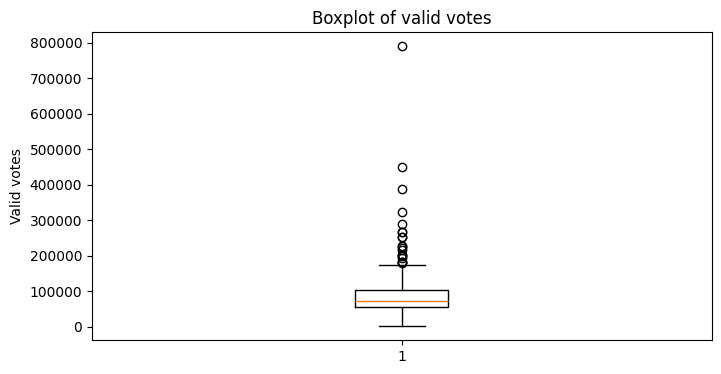

In [114]:
#plot a boxplot of the valid votes
fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(brexit_data['Valid_Votes'])
ax.set_title('Boxplot of valid votes')
ax.set_ylabel('Valid votes')
plt.show()



In [115]:
#remove the outliers from the valid votes, that are the values greater than 1.5 times the interquartile range
Q1 = brexit_data['Valid_Votes'].quantile(0.25)
Q3 = brexit_data['Valid_Votes'].quantile(0.75)
IQR = Q3 - Q1
brexit_data_no_outliers = brexit_data[(brexit_data['Valid_Votes'] >= Q1 - 1.5 * IQR) & (brexit_data['Valid_Votes'] <= Q3 + 1.5 * IQR)]
brexit_data_no_outliers


,Area,Remain,Leave,Valid_Votes
0,Peterborough,34176,53216,87392
1,Luton,36708,47773,84481
2,Southend-on-Sea,39348,54522,93870
3,Thurrock,22151,57765,79916
4,Bedford,41497,44569,86066
...,...,...,...,...
373,Barnsley,38951,83958,122909
374,Doncaster,46922,104260,151182
375,Rotherham,44115,93272,137387
378,Calderdale,46950,58975,105925


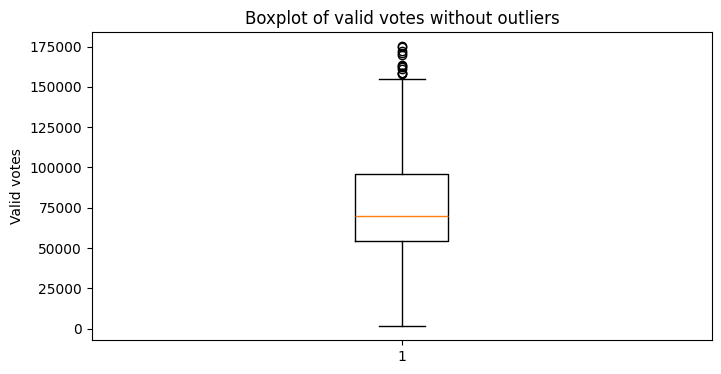

In [116]:
#do another boxplot of the valid votes
fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(brexit_data_no_outliers['Valid_Votes'])
ax.set_title('Boxplot of valid votes without outliers')
ax.set_ylabel('Valid votes')
plt.show()


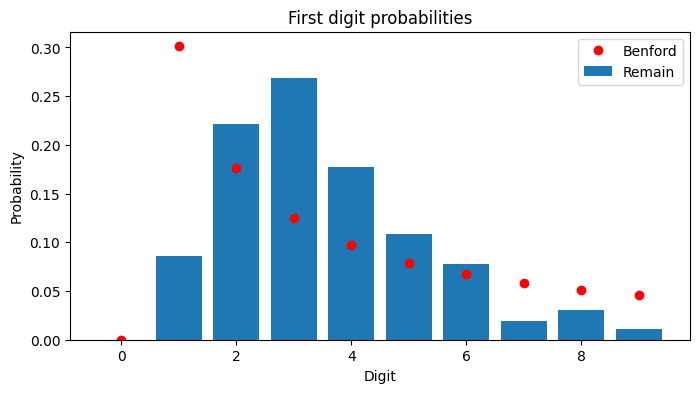

In [117]:
#apply the benford's law to the remain column
remain_benford = data_digit_probabilities(brexit_data_no_outliers['Leave'], 1)
remain_benford

#plot the remain_benford
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ro', label='Benford')
ax.bar(remain_benford.keys(), remain_benford.values(), label='Remain')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


In [118]:
N=len(brexit_data_no_outliers)
N


361

In [119]:
#compute the z-statistic for the remain_benford first digit
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(remain_benford,1))[1:]
N=len(brexit_data_no_outliers)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")


Z-statistic value: [28.89459128343765, 90.91139687538478, 165.1291140286383, 250.58679733472994, 346.15488921712557, 450.9333593966032, 564.2101622534723, 685.4098696606122, 814.0569571377213]


In [120]:
# Example usage with Z-values
z_values = z_value # Replace with your Z-statistics
print("\nInterpretation of Z-statistics at each significance level:")

for level, cutoff in cutoff_values.items():
    print(f"\nAt {level} significance level (cutoff = {cutoff:.3f}):")
    for i, z in enumerate(z_values):
        if abs(z) > cutoff:
            print(f"  Pair {i + 1}: |Z| = {abs(z):.3f} > {cutoff:.3f} (Significant, data does not follow Benford's Law, reject H0)")
        else:
            print(f"  Pair {i + 1}: |Z| = {abs(z):.3f} <= {cutoff:.3f} (Not Significant, data follows Benford's Law, fail to reject H0)")


Interpretation of Z-statistics at each significance level:

At 0,1% significance level (cutoff = 3.291):
  Pair 1: |Z| = 28.895 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 2: |Z| = 90.911 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 3: |Z| = 165.129 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 4: |Z| = 250.587 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 5: |Z| = 346.155 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 6: |Z| = 450.933 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 7: |Z| = 564.210 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 8: |Z| = 685.410 > 3.291 (Significant, data does not follow Benford's Law, reject H0)
  Pair 9: |Z| = 814.057 > 3.291 (Significant, data does not follow Benford's Law, reject H0)

At 1% significance level (cutoff = 2.576):
  Pair 1: |Z| =

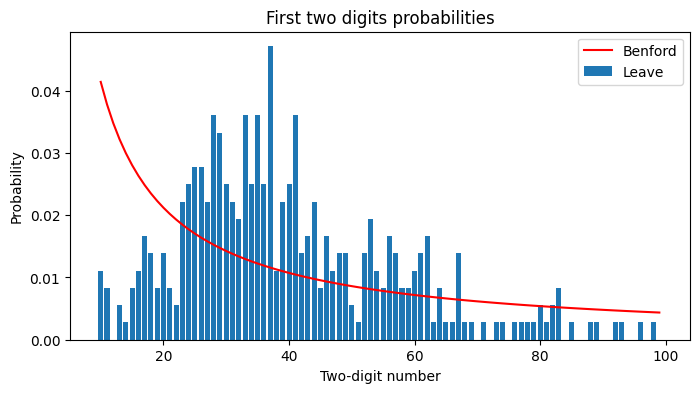

In [121]:
#use brexit_data_no_outliers for the first two digits
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'r', label='Benford')
ax.bar(data_digit_probabilities_firsttwo(brexit_data_no_outliers['Leave']).keys(), data_digit_probabilities_firsttwo(brexit_data_no_outliers['Leave']).values(), label='Leave')
ax.set_title('First two digits probabilities')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


In [122]:
AP

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [123]:
#multiply all the rows of remain_benford by total_votes
obs_freq = [value * total_votes for value in remain_benford.values()]
obs_freq

NameError: name 'total_votes' is not defined

In [95]:
#chi-squared test


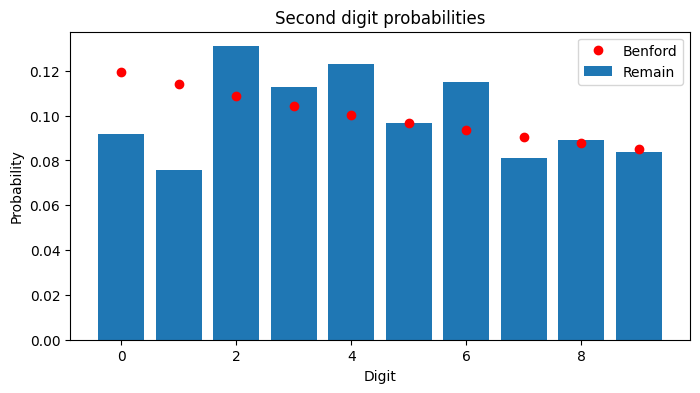

In [96]:
#do the same for the second digit
remain_benford = data_digit_probabilities(brexit_data['Remain'], 2)
remain_benford

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ro', label='Benford')
ax.bar(remain_benford.keys(), remain_benford.values(), label='Remain')
ax.set_title('Second digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()
